<a href="https://colab.research.google.com/github/langfordzd/burst_regimes/blob/main/walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install neurodsp
!pip install bycycle
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 27.2 MB/s eta 0:00:00


In [11]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/bursts_walkthrough/walkthrough')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config as cfg
import helpers as hp
import itertools
import detectors as d_m
from multiprocessing import Pool, cpu_count
import time
import pickle
from scipy.stats import lognorm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


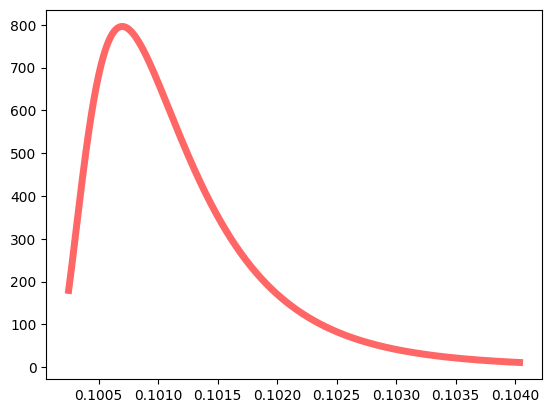

In [12]:
#%%[loc,chan,ep,e,a,f,p,tf,ts,b,ids]
r_seed = 0
t_num = 100
cfg.t_num = t_num
depth_point = (1, 50)
cycles = [6, 9]
shape = 0.6
loc = 0.1
scale = 0.001

distribution = ('lognorm', shape, loc, scale)
probs = [0.7, 0.3]
trials, chars = hp.simmer(r_seed,t_num,depth_point,cycles,distribution,probs)
cfg.trials = trials

mean, var, skew, kurt = lognorm.stats(shape,loc=loc,scale=scale, moments='mvsk')
x = np.linspace(lognorm.ppf(0.01, shape,loc=loc,scale=scale),lognorm.ppf(0.99, shape,loc=loc,scale=scale), 1000)
plt.plot(x, lognorm.pdf(x, shape,loc=loc,scale=scale),'r-', lw=5, alpha=0.6, label='amplitude density')
plt.show()

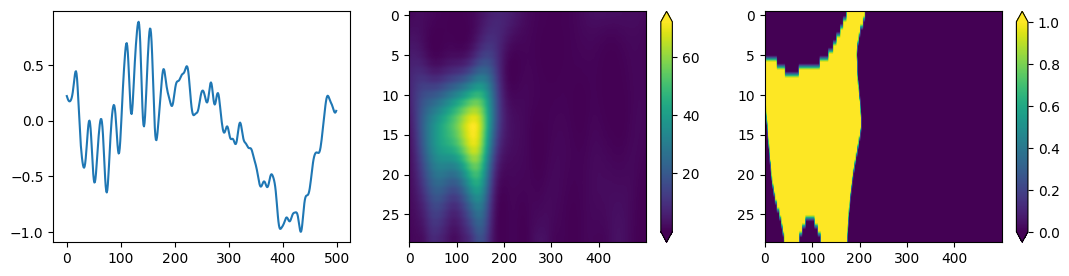

In [13]:
#%%
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)
t = 0
ax1.plot(trials[t][3][250:750])
tfr = trials[t][7][:,250:750]
tfr_o = ax2.imshow(tfr,aspect='auto')
cbar = fig.colorbar(tfr_o,ax=ax2, extend='both')
from scipy import ndimage
labeled_image, num_features = ndimage.label(tfr>6)
tfr_m = ax3.imshow(labeled_image,aspect='auto')
cbar = fig.colorbar(tfr_m,ax=ax3, extend='both')
plt.show()

In [14]:
pt_recov = [d_m.pow_chars(s) for s in [trials]]
cfg.pt_recov = pd.DataFrame(list(itertools.chain.from_iterable(pt_recov)),
                        columns=['loc','chan','ep','ids','start','end','duration'])

In [17]:
with open("/content/drive/MyDrive/bursts_walkthrough/walkthrough/wte", "rb") as fp:   # Unpickling
   whichToEval = pickle.load(fp)

#whichToEval = whichToEval[:]
cfg.whichToEval = whichToEval
trial_index = np.arange(len(trials))
which_index = np.arange(len(whichToEval))
trial_eval_product = list(itertools.product(trial_index, which_index))

In [18]:
start_time = time.time()
num_cores = cpu_count()
pool = Pool(processes=num_cores)
cycler =  pool.starmap(d_m.cycler_worker, trial_eval_product)
pool.close()
pool.join()
print("--- %s minutes ---" % ((time.time() - start_time) / 60))

--- 1.1387231787045797 minutes ---


In [19]:
lis = list()
twos = [4,8,12,13,14,15,16]
threes = [0,1,2,3,5,6,7,9,10,11]
for c in cycler:
    lis.append([c[0],c[1],c[2],c[3],c[4],c[5],c[6],c[7],len(c[8]),len(c[9]),len(c[10]),len(c[11])])
df = pd.DataFrame(lis,columns=['loc', 'chan', 'ep', 'ids', 't', 'toE',
                               'stat', 'count',
                               'ccu','ccc','ptu','ptc'])
evals = []
temp = df
temp['has_b'] = temp['count']>0
mean = temp.groupby('toE').mean()
unis  = temp.groupby('toE').sum()
cr = mean[['stat']]
unis  = unis[['ccu','ccc','ptu','ptc','count','has_b']]
unis['stat'] = cr['stat']
unis_twos = unis.iloc[twos]
unis_threes = unis.iloc[threes]
maxx2 = unis_twos['stat'].argmax()
maxx3 = unis_threes['stat'].argmax()
idx2 = unis_twos.index[maxx2]
idx3 = unis_threes.index[maxx3]
evals.append([idx2,idx3])

<ipython-input-19-f927fdf4b538>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean = temp.groupby('toE').mean()
<ipython-input-19-f927fdf4b538>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  unis  = temp.groupby('toE').sum()


In [20]:
tot_amps = []
tot_durations = []
tot_frequencies = []
tot_common = []
tot_cc = []

for e in evals:
    indices2 = [i for i, x in enumerate(cycler) if x[5] == e[0]]
    indices3 = [i for i, x in enumerate(cycler) if x[5] == e[1]]
    temp2 = [cycler[index] for index in indices2]
    temp3 = [cycler[index] for index in indices3]

    cc_uniq = pd.concat([i[8] for i in temp2])
    cc_comm = pd.concat([i[9] for i in temp2])
    cc_uniq3 = pd.concat([i[8] for i in temp3])
    cc_comm3 = pd.concat([i[9] for i in temp3])
    cc_uniq['which'] = 'cc2'
    cc_comm['which'] = 'co2'
    cc_uniq3['which'] = 'cc3'
    cc_comm3['which'] = 'co3'

    ccs = pd.concat([cc_uniq,cc_comm,cc_uniq3,cc_comm3])
    gb = ccs.groupby(['ids'])

    cc_drop_overlaps = []
    for name, g in gb:
        g = g.sort_values(by='end', ascending=False)
        g['overlap'] = g['end'].gt(g['start'].shift(fill_value=0))
        g['group'] = g['overlap'].eq(False).cumsum()
        g = g.drop_duplicates(subset='group').drop(columns=['overlap','group'])
        cc_drop_overlaps.append(g)

    cc = pd.concat(cc_drop_overlaps)
   # #%% this is confusing because some are the same, some overlap becuase of imregionalmax
    pt_uniq2 = pd.concat([i[10] for i in temp2])
    pt_uniq3 = pd.concat([i[10] for i in temp3])
    pt_uniq = pd.concat([pt_uniq2,pt_uniq3]).drop_duplicates().reset_index(drop=True)

    pt_comm2 = pd.concat([i[11] for i in temp2])
    pt_comm3 = pd.concat([i[11] for i in temp3])
    pt_comm = pd.concat([pt_comm2,pt_comm3]).drop_duplicates().reset_index(drop=True)

    #pt_uniq.reset_index(inplace=True)
    #pt_comm.reset_index(inplace=True)
    pt_uniq['which'] = 'pt'
    pt_comm['which'] = 'pt_com'
    pt = pd.concat([pt_uniq, pt_comm])
    #pt.sort_values(by=['which'], inplace=True)
    #you can have a common in pt with cc2 or cc3, so you have to drop all commons, based on cc2 or 3, not just one
    pt.drop_duplicates(subset=['ids', 'start','end'], keep=False,inplace=True,ignore_index=True)
    pt = pt[pt['which']=='pt']
    com_ = pd.concat([cc, pt])#, cc_comm, pt_comm])
    tot_common.append(com_)

com1 = pd.concat(tot_common)
com1['which'] = com1['which'].replace(['cc2','cc3','pt','co2','co3','pt_com'],['cc','cc','pt','co','co','co'])

<ipython-input-20-e51121fb7079>:26: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, g in gb:


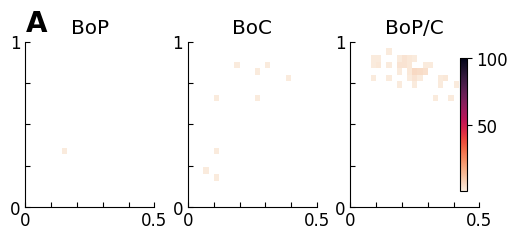

In [21]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import numpy as np
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 12
fig = plt.figure(1, figsize=(9, 12))
gs = gridspec.GridSpec(9, 9)
gs.update(wspace=0.7, hspace=0.9)
background = 'whitesmoke'
kde_color= '0.4'
v_val = 100
###############################################################################
###############################################################################
xtr = fig.add_subplot(gs[0:2, 0:2])
xtr.text(0, 1.025, "A", fontsize=20, fontweight="bold", va="bottom", ha="left",
                  transform=xtr.transAxes)
sub = com1[com1['which']=='pt']
c = sns.color_palette("rocket_r", as_cmap=True)
xtr.hist2d(sub['duration'],sub['amp'], bins=(25, 25), cmap=c,cmin=0.1,vmin=1, vmax=v_val,
             range=[[0, 0.5], [0, 1]])
xtr.set_ylim([0, 1])
xtr.set_xlim([0, 0.5])
xtr.spines['right'].set_visible(False)
xtr.spines['top'].set_visible(False)
xtr.set_yticks([0, 0.25, 0.5, 0.75, 1])
xtr.set_yticklabels(['0', '','','', '1'])
xtr.set_xticks([0, 0.1, 0.2, 0.3,0.4,0.5])
xtr.set_xticklabels(['0', '', '', '', '','0.5'])
xtr.tick_params(axis="both",direction="in")
xtr.set(ylabel='',xlabel='')
xtr.set_title('BoP')
xtr.yaxis.set_label_coords(-0.05, 0.5)
xtr.xaxis.set_label_coords(0.5, -0.05)
###############################################################################
xtr = fig.add_subplot(gs[0:2, 2:4])
sub = com1[com1['which']=='cc']
p = xtr.hist2d(sub['duration'],sub['amp'], bins=(25, 25), cmap=c,cmin=0.1, vmin=1, vmax=v_val,
              range=[[0, 0.5], [0, 1]])
xtr.set_ylim([0, 1])
xtr.set_xlim([0, 0.5])
xtr.spines['right'].set_visible(False)
xtr.spines['top'].set_visible(False)
xtr.set_yticks([0, 0.25, 0.5, 0.75, 1])
xtr.set_yticklabels(['0', '','','', '1'])
xtr.set_xticks([0, 0.1, 0.2, 0.3,0.4,0.5])
xtr.set_xticklabels(['0', '', '', '', '','0.5'])
xtr.tick_params(axis="both",direction="in")
xtr.set(xlabel=None,ylabel=None)
xtr.set_title('BoC')
###############################################################################
xtr = fig.add_subplot(gs[0:2, 4:6])
sub = com1[com1['which']=='co']
p = xtr.hist2d(sub['duration'],sub['amp'], bins=(25, 25), cmap=c,cmin=0.1,vmin=1, vmax=v_val,
              range=[[0, 0.5], [0, 1]])
plt.colorbar(p[3],ax=xtr, shrink=0.8, pad = -0.15)
xtr.set_ylim([0, 1])
xtr.set_xlim([0, 0.5])
xtr.spines['right'].set_visible(False)
xtr.spines['top'].set_visible(False)
xtr.set_yticks([0, 0.25, 0.5, 0.75, 1])
xtr.set_yticklabels(['0', '','','', '1'])
xtr.set_xticks([0, 0.1, 0.2, 0.3,0.4,0.5])
xtr.set_xticklabels(['0', '', '', '', '','0.5'])
xtr.tick_params(axis="both",direction="in")
xtr.set(xlabel=None,ylabel=None)
xtr.set_title('BoP/C')
plt.show()